In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS

The observing period is the whole year of -2000 B.C.E. ~ 0 B.C.
To represent the epoch before the common era, I use the Julian date.

I calculate the altitude and azimuth of Sun and Canopus among 4:00~8:00 in autumnal equinox and 16:00~20:00 in vernal equinox for every year.

In [5]:
def observable_duration(obs_time):
    """
    """

    # Assume we have an observer in Tai Mountain.
    taishan = EarthLocation(lat=36.2*u.deg, lon=117.1*u.deg, height=1500*u.m)

    utcoffset = +8 * u.hour  # Daylight Time
    midnight = obs_time - utcoffset

    # Position of the Canopus with the proper motion correction at the beginning of the year.
    # This effect is very small.
    dt_jyear = obs_time.jyear - 2000.0
    ra = 95.98787790 * u.deg + 19.93 * u.mas * dt_jyear
    dec = -52.69571787 * u.deg + 23.24 * u.mas * dt_jyear
    hip30438 = SkyCoord(ra=ra, dec=dec, frame="icrs")

    delta_midnight = np.arange(0, 24, 1./30) * u.hour # Interval of 2 minutes
    obser_time = midnight + delta_midnight

    local_frame = AltAz(obstime=obser_time,
                        location=taishan)
    hip30438altazs = hip30438.transform_to(local_frame)

    # position of Sun
    from astropy.coordinates import get_sun
    sunaltazs = get_sun(obser_time).transform_to(local_frame)

    mask = (sunaltazs.alt < -0*u.deg) & (hip30438altazs.alt > 0)
    observable_time = delta_midnight[mask]
    
    # observable_time
    if len(observable_time):
        beg_time = observable_time.min().to('hr').value
        end_time = observable_time.max().to('hr').value
    else:
        beg_time, end_time = 0, 0 

    return beg_time, end_time

In [6]:
# Vernal equinox
year_arr = np.arange(0, 2000, 1)

# Number of days for every year
date_nb = np.ones_like(year_arr)
date_nb = np.where(year_arr % 4 == 0, 366, 365)
date_nb = np.where((year_arr % 100 == 0) & (
    year_arr % 400 != 0), 365, date_nb)

total_date_nb = np.zeros_like(year_arr)
for i in range(year_arr.size):
    total_date_nb[i] = np.sum(date_nb[:i+1])

# Autumnal equinox of every year
obs_time_ver = Time("0000-03-21 00:00:00") - total_date_nb * u.day

# Calculate the observable time of everyday
beg_time1 = np.zeros_like(obs_time_ver)
end_time1 = np.zeros_like(obs_time_ver)
obs_dur1 = np.zeros_like(obs_time_ver) # Observable duration


for i, obs_timei in enumerate(obs_time_ver):
    # we calculate the 30 days before and after the equinox
    delta_date = np.arange(-5, 5, 1) * u.day
    obs_time0 = obs_timei + delta_date

    beg_time_ver = np.zeros_like(obs_time0)
    end_time_ver = np.zeros_like(obs_time0)

    for j, obs_time0j in enumerate(obs_time0):
        # Vernal equninox
        beg_time_ver[j], end_time_ver[j] = observable_duration(obs_time0j)
        
    obs_dur_ver = end_time_ver - beg_time_ver
    
    obs_dur1[i] = np.max(obs_dur_ver)
    beg_time1[i] = beg_time_ver[obs_dur_ver == obs_dur1[i]][0]
    end_time1[i] = end_time_ver[obs_dur_ver == obs_dur1[i]][0]

In [7]:
# Autumnal equinox
year_arr = np.arange(0, 2000, 1)

# Number of days for every year
date_nb = np.ones_like(year_arr)
date_nb = np.where(year_arr % 4 == 0, 366, 365)
date_nb = np.where((year_arr % 100 == 0) & (
    year_arr % 400 != 0), 365, date_nb)

total_date_nb = np.zeros_like(year_arr)
for i in range(year_arr.size):
    total_date_nb[i] = np.sum(date_nb[:i+1])

# Autumnal equinox of every year
obs_time_aut = Time("0000-09-23 00:00:00") - total_date_nb * u.day

# Calculate the observable time of everyday
beg_time2 = np.zeros_like(obs_time_aut)
end_time2 = np.zeros_like(obs_time_aut)
obs_dur2 = np.zeros_like(obs_time_aut) # Observable duration


for i, obs_timei in enumerate(obs_time_aut):
    # we calculate the 30 days before and after the equinox
    delta_date = np.arange(-5, 5, 1) * u.day
    obs_time0 = obs_timei + delta_date

    beg_time_aut = np.zeros_like(obs_time0)
    end_time_aut = np.zeros_like(obs_time0)

    for j, obs_time0j in enumerate(obs_time0):
        # Vernal equninox
        beg_time_aut[j], end_time_aut[j] = observable_duration(obs_time0j)
        
    obs_dur_aut = end_time_aut - beg_time_aut
    
    obs_dur2[i] = np.max(obs_dur_aut)
    beg_time2[i] = beg_time_aut[obs_dur_aut == obs_dur2[i]][0]
    end_time2[i] = end_time_aut[obs_dur_aut == obs_dur2[i]][0]

I assume that the Canopus can be observed by the local observer only when the observable duration in one day is longer than 10 minitues.
With such an assumption, I determine the observable period of the Canopus.

In [14]:
# Save data
np.save("multi_epoch-max-duration-output",
        [obs_time_ver.jyear, beg_time1, end_time1, obs_dur1, 
         obs_time_aut.jyear, beg_time2, end_time2, obs_dur2])

# For vernal equinox
mask1 = (obs_dur1 >= 1./60)
# mask1 = (obs_dur1 >= 0)
observable_date1 = obs_time_ver[mask1]

# For Autumnal equinox
mask2 = (obs_dur2 >= 1./60)
# mask2 = (obs_dur2 >= 0)
observable_date2 = obs_time_aut[mask2]

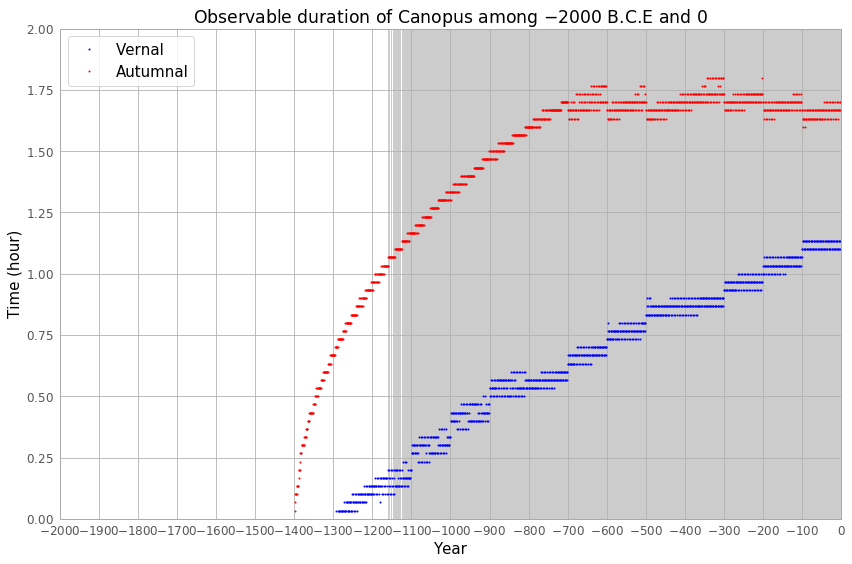

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(observable_date1.jyear, obs_dur1[mask1],
          "b.", ms=2, label="Vernal")
ax.plot(observable_date2.jyear, obs_dur2[mask2],
          "r.", ms=2, label="Autumnal")

ax.fill_between(obs_time_aut.jyear, 0, 24,
                 (obs_dur1 >= 1./6) & (obs_dur2 >= 1./6), color="0.8", zorder=0)

ax.set_xlabel("Year", fontsize=15)
ax.set_xlim([-2000, 0])
ax.set_xticks(np.arange(-2000, 1, 100))

ax.set_ylim([0, 2.0])
ax.set_ylabel("Time (hour)", fontsize=15)
ax.set_title("Observable duration of Canopus among $-2000$ B.C.E and 0")

ax.legend(fontsize=15)

fig.tight_layout()
plt.savefig("multi_epoch-max-duration.eps", dpi=100)
plt.savefig("multi_epoch-max-duration.png", dpi=100)